# Initialization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
iterations = 5
Key = 'GR' # MD, GR, ALL
synthetic_data_generation = False
controlled_random_sampling = True

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score
df = pd.read_csv('/content/drive/MyDrive/Predict_Risk_of_Depression/Fin_Data.csv')

df.fillna(-1, inplace=True)
#df = df[~df.isin(['True']).any(axis=1)]
#df = df.dropna()
#df = df.astype(float)
#df = df.astype(str)

# Dataset Segmentation

In [ ]:
# split train and test data
data = df[df['degree'] == 1]
_, data_test = train_test_split(data, test_size=0.2, random_state=32)
data = df.drop(data_test.index)

data_test.reset_index(drop = True , inplace = True)
X_test = data_test.drop("Depression", axis=1).drop("Depression_point", axis=1)
y_test = data_test["Depression"]

In [ ]:
# cut data base different group
if Key == 'MD':
  data = data[data['degree'] == 1]
elif Key == 'GR':
  data = data[data['graduate_student'] == 1]
else:
  None

data.reset_index(drop = True , inplace = True)

# Controlled Random Sampling

In [ ]:
if (controlled_random_sampling == True):
  # class count
  class_count_0, class_count_1 = data['Depression'].value_counts()

  # Separate class
  class_0 = data[data['Depression'] == 0]
  class_1 = data[data['Depression'] == 1]
  print('class 0:', class_0.shape)
  print('class 1:', class_1.shape)

  from sklearn.cluster import KMeans
  class_0_quarter=KMeans(n_clusters=4, random_state=0).fit(class_0)

  class_0_0=class_0[class_0_quarter.labels_==0]
  class_0_1=class_0[class_0_quarter.labels_==1]
  class_0_2=class_0[class_0_quarter.labels_==2]
  class_0_3=class_0[class_0_quarter.labels_==3]

  nk = int(class_1.shape[0]/4)
  #select points nk * 4 ponits from 4 clusters
  class_0_quarter_0=class_0_0.sample(n=nk, replace=True, weights=None, random_state=0, axis=0)
  class_0_quarter_1=class_0_1.sample(n=nk, replace=True, weights=None, random_state=0, axis=0)
  class_0_quarter_2=class_0_2.sample(n=nk, replace=True, weights=None, random_state=0, axis=0)
  class_0_quarter_3=class_0_3.sample(n=nk, replace=True, weights=None, random_state=0, axis=0)

  frames=[class_0_quarter_0,class_0_quarter_1,class_0_quarter_2,class_0_quarter_3,class_1]
  class_896points=pd.concat(frames)

  from sklearn.utils import shuffle
  shuffled_data = shuffle(class_896points)

  X_shuffled_data = shuffled_data.drop("Depression", axis=1).drop("Depression_point", axis=1)
  y_shuffled_data = shuffled_data["Depression"]
  X, _, y, _ = train_test_split(X_shuffled_data, y_shuffled_data, test_size=0.2, random_state=32)

# Synthetic Data Generation (Optional)

In [ ]:
if (synthetic_data_generation==True):
  from imblearn.over_sampling import SMOTE

  sm = SMOTE(sampling_strategy="minority")
  X_resampled, y_resampled = sm.fit_resample(X, y)
  X, X_test, y, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize a list to store the accuracy scores
lr_scores = []
best_score = 0

# Loop over the number of Monte Carlo iterations
for i in range(iterations):
  # Split the data into training and testing sets
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
 
  # Train the model on the training data
  temp_model = LogisticRegression(penalty='l2', C=1.0, max_iter=100, solver='sag')
  temp_model.fit(X_train, y_train)

  # Evaluate the model on the testing data
  y_pred = temp_model.predict(X_valid)
  score = roc_auc_score(y_valid, y_pred)
  lr_scores.append(score)


  if score > best_score:
    lr_model = temp_model
    best_score = score

# Calculate the average accuracy score
print("Average accuracy score:", np.mean(lr_scores))
print("Best accuracy score:", best_score)

Average accuracy score: 0.7621702402828014
Best accuracy score: 0.781060606060606


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
y_pred = lr_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8507614213197969

# SVM - Support Vector Machine

In [ ]:
from sklearn import svm

# Initialize a list to store the accuracy scores
svm_scores = []
best_score = 0

for i in range(iterations):
  # Split the data into training and testing sets
  X_train, X_vaild, y_train, y_valid = train_test_split(X, y, test_size=0.25)

  # Train the model on the training data
  temp_model = svm.SVC(C = 1.0, max_iter =  10000)
  temp_model.fit(X_train, y_train)

  # Evaluate the model on the testing data
  y_pred = temp_model.predict(X_vaild)
  score = roc_auc_score(y_valid, y_pred)
  svm_scores.append(score)

  if score > best_score:
    svm_model = temp_model
    best_score = score

# Calculate the average accuracy score
print("Average accuracy score:", np.mean(svm_scores))
print("Best accuracy score:", best_score)

Average accuracy score: 0.7908224983051598
Best accuracy score: 0.8460969293377729


In [ ]:
y_pred = svm_model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.759563641688326

# Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

temp_model = Sequential([
    Dense(units=12, input_dim=26,activation='relu'),
    Dense(units=9, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

temp_model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

temp_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 12)                324       
                                                                 
 dense_82 (Dense)            (None, 9)                 117       
                                                                 
 dense_83 (Dense)            (None, 1)                 10        
                                                                 
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Initialize a list to store the accuracy scores
nn_scores = []
best_score = 0

# Loop over the number of Monte Carlo iterations
for i in range(iterations):
  # Split the data into training and testing sets
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

  # Train the model on the training data
  history = ""
  history = temp_model.fit(X_train, y_train, epochs=15)

  # Evaluate the model on the testing data
  y_pred = (temp_model.predict(X_valid) > 0.5).astype("int32")
  score = roc_auc_score(y_valid, y_pred)
  nn_scores.append(score)

  if score > best_score:
    nn_model = temp_model
    best_score = score


# Calculate the average accuracy score
print("Average accuracy score:", np.mean(nn_scores))
print("Best accuracy score:", best_score)

In [ ]:
y_pred = nn_model.predict(X_test)
roc_auc_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=(24, 6), dpi=80)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(24, 6), dpi=80)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# CART - Classification And Regression Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize a list to store the accuracy scores
cr_scores = []
best_score = 0

# Loop over the number of Monte Carlo iterations
for i in range(iterations):
  # Split the data into training and testing sets
  X_train, X_vaild, y_train, y_valid = train_test_split(X, y, test_size=0.25)

  # Train the model on the training data
  temp_model = DecisionTreeClassifier(criterion='gini')
  temp_model.fit(X_train, y_train)

  # Evaluate the model on the testing data
  y_pred = temp_model.predict(X_vaild)
  score = roc_auc_score(y_valid, y_pred)
  cr_scores.append(score)

  if score > best_score:
    cr_model = temp_model
    best_score = score

# Calculate the average accuracy score
print("Average accuracy score:", np.mean(cr_scores))
print("Best accuracy score:", best_score)

Average accuracy score: 0.7567816091954023
Best accuracy score: 0.7647988505747126


In [ ]:
y_pred = cr_model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7635263755170771

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a list to store the accuracy scores
rf_scores = []
best_score = 0

# Loop over the number of Monte Carlo iterations
for i in range(iterations):
  # Split the data into training and testing sets
  X_train, X_vaild, y_train, y_valid = train_test_split(X, y, test_size=0.25)

  # Train the model on the training data
  temp_model = RandomForestClassifier()
  temp_model.fit(X_train, y_train)

  # Evaluate the model on the testing data
  y_pred = temp_model.predict(X_vaild)
  score = roc_auc_score(y_valid, y_pred)
  rf_scores.append(score)

  if score > best_score:
    rf_model = temp_model
    best_score = score

# Calculate the average accuracy score
print("Average accuracy score:", np.mean(rf_scores))
print("Best accuracy score:", best_score)

Average accuracy score: 0.8053160919540229
Best accuracy score: 0.808764367816092


In [ ]:
y_pred = rf_model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7804297690083097

# XGBoost

In [ ]:
import xgboost as xgb

# Initialize a list to store the accuracy scores
xgc_scores = []
best_score = 0

# Loop over the number of Monte Carlo iterations
for i in range(iterations):
  # Split the data into training and validating sets
  X_train, X_vaild, y_train, y_valid = train_test_split(X, y, test_size=0.25)

  # Train the model on the training data'''enable_categorical = True,'''
  temp_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=15, min_child_weight=6, random_state=30)
  temp_model.fit(X_train, y_train)

  # Evaluate the model on the validating data
  y_pred = temp_model.predict(X_vaild)
  score = roc_auc_score(y_valid, y_pred)
  xgc_scores.append(score)

  if score > best_score:
    xgc_model = temp_model
    best_score = score

# Calculate the average accuracy score
print("Average accuracy score:", np.mean(xgc_scores))
print("Best accuracy score:", best_score)

Average accuracy score: 0.8880773935855177
Best accuracy score: 0.8890016313502584


In [ ]:
y_pred = xgc_model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7499359373284035

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Initialize a list to store the accuracy scores
xgr_scores = []
best_score = 0

# Loop over the number of Monte Carlo iterations
for i in range(iterations):
  # Split the data into training and validating sets
  X_train, X_vaild, y_train, y_valid = train_test_split(X, y, test_size=0.25)

  # Train the model on the training data'''enable_categorical = True,'''
  temp_model = xgb.XGBRegressor(objective ='count:poisson', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
  temp_model.fit(X_train, y_train)

  # Evaluate the model on the validating data
  y_pred = temp_model.predict(X_vaild)
  score  = mean_squared_error(y_valid, y_pred)
  xgr_scores.append(score)

  if score > best_score:
    xgr_model = temp_model
    best_score = score

# Calculate the average accuracy score
print("Average mse score:", np.mean(xgr_scores))
print("Best mse score:", best_score)

Average mse score: 0.08490372
Best mse score: 0.08560574


xgb regression Cannot use ROC score 

In [ ]:
y_pred = xgr_model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.16198625

# Visualization

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

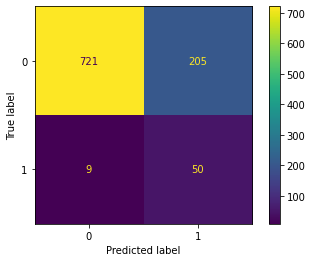

In [199]:
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
classes = [0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

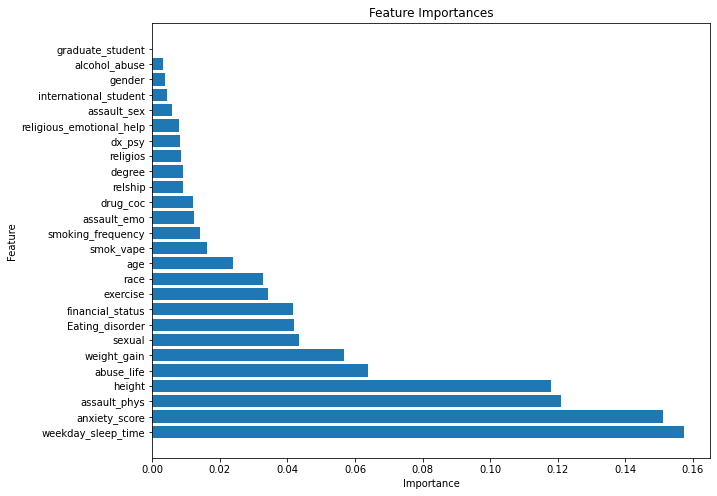

In [198]:
# get feature importances with names
importances = xgr_model.feature_importances_
feature_names = X.columns.tolist()

# create dataframe of feature importances with names
dt = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
dt = dt.sort_values(by='Importance', ascending=False)

# plot feature importances with names
plt.figure(figsize=(10, 8))
plt.barh(dt['Feature'], dt['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [197]:
# print feature importances with names
print(dt)

                     Feature  Importance
4              anxiety_score    0.227000
15                    height    0.102963
2                        age    0.098991
24        weekday_sleep_time    0.076478
25               weight_gain    0.058726
12          financial_status    0.051597
21                    sexual    0.050019
11                  exercise    0.049577
18                  religios    0.046234
20                   relship    0.031860
0            Eating_disorder    0.027409
23         smoking_frequency    0.024741
1                 abuse_life    0.021620
6               assault_phys    0.020950
17                      race    0.019027
13                    gender    0.018138
16     international_student    0.012241
19  religious_emotional_help    0.012037
5                assault_emo    0.010591
9                   drug_coc    0.010112
7                assault_sex    0.007803
22                 smok_vape    0.007372
3              alcohol_abuse    0.005532
8               

# Model Evaluation

In [ ]:
# scores of models based on for 'Key' students
models = [lr_model, svm_model, nn_model, cr_model, rf_model, xgc_model, xgr_model]
scores = []

for i in range(0,7):
  temp_model = models[i]

  if temp_model==nn_model:
    y_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
  else:
    y_pred = temp_model.predict(X_test)

  score = roc_auc_score(y_test, y_pred)#accuracy_score
  scores.append(score)

  print(i+1, temp_model)
  print("Average accuracy score:", score)

# Save and Load

In [ ]:
# save scores in txt file
with open('/content/drive/MyDrive/Predict_Risk_of_Depression/p/'+Key+'_score_list.txt', 'w') as file:

    for score in scores:
        file.write(str(score) + '\n')

In [ ]:
# save model
import joblib

for i in range(0,7):
  model = models[i]

  joblib.dump(model, '/content/drive/MyDrive/Predict_Risk_of_Depression/p/'+'No.'+str(i)+'_group:'+str(Key)+'_model.joblib')


In [ ]:
# load model
import joblib

Key = 'GR'
lr_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.0_group:'+Key+'_model.joblib')
svm_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.1_group:'+Key+'_model.joblib')
nn_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.2_group:'+Key+'_model.joblib')
cr_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.3_group:'+Key+'_model.joblib')
rf_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.4_group:'+Key+'_model.joblib')
xgc_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.5_group:'+Key+'_model.joblib')
xgr_model = joblib.load('/content/drive/MyDrive/Predict_Risk_of_Depression/p/No.6_group:'+Key+'_model.joblib')